In [1]:
%%capture
!pip install pytorch_lightning

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import pytorch_lightning as pl

import os
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
workind_directory = "/content/drive/MyDrive/Map_construction/source"
os.chdir(workind_directory)
os.getcwd()

'/content/drive/MyDrive/Map_construction/source'

### Tensorboard things

In [5]:
import tensorboard
import tensorflow

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [6]:
%load_ext tensorboard
tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
logdir = os.path.join("logs")
writer = SummaryWriter(log_dir=logdir)

In [8]:
class model_traj2graph(pl.LightningModule):
    def __init__(self):
        super(model_traj2graph, self).__init__()
        self.traj_len = 30*3
        self.embedding_size = 64
        self.transformer_size = 1024
        self.nheads = 2
        self.ntransformer_layers = 2
        self.final_size = 32*32
        
        self.w = 32
        self.h = 32
        
        self.embedding_layer = nn.Linear(self.traj_len, self.embedding_size)
        self.single_transformer_layer = nn.TransformerEncoderLayer(d_model = self.embedding_size, 
                                                            nhead = self.nheads, 
                                                            dim_feedforward=self.transformer_size, 
                                                            batch_first = True)
        
        self.transformer_layer = nn.TransformerEncoder(self.single_transformer_layer, self.ntransformer_layers)
        
        self.linear_decoder = nn.Sequential(
            # nn.Linear(self.embedding_size, self.final_size//4),
            # nn.ReLU(),
            nn.Linear(self.embedding_size, self.final_size//2),
            nn.ReLU(),
            nn.Linear(self.final_size//2, self.final_size),
            nn.ReLU(),
        )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(1, 1, 5, padding = 2),
            nn.ReLU(),
            nn.Conv2d(1, 1, 5, padding = 2),
            nn.ReLU()
        )
        
        self.lr = 0.005
        self.loss = nn.MSELoss()

    def forward(self, x, mask):
        batch_size, _, _ = x.size()
        
        x = self.embedding_layer(x)
        x = self.transformer_layer(x, src_key_padding_mask = mask)
        x = self.linear_decoder(x)
        x = x.reshape(batch_size, -1, self.w, self.h)
        #x = x.reshape(-1, 1, self.w, self.h)
        #x = self.final_conv(x)
        #x = x.reshape(batch_size, -1, self.w, self.h)
        #x = x.squeeze(2)
        x, x_indexes = torch.max(x, dim = 1)
        
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        batch_x, lengths, mask = x
        logits = self.forward(batch_x, mask)
        loss = self.loss(logits, y)
        self.log("Training loss", loss, on_step=False, on_epoch=True)
        return loss


### Load data

In [9]:
dataset = "500m_chicago_cropped_rotated_15k"
dataset_path = "../data/datasets/" + dataset + "/"

In [10]:
with open(dataset_path + "data.pickle", "rb") as f:
    data = pickle.load(f)

In [13]:
# Try some things

enc = nn.TransformerEncoderLayer(3,1, batch_first = True, dropout = 0)
model = nn.TransformerEncoder(enc, 1)

In [14]:
x = torch.Tensor([[[1,2,3],[0,0,0]],[[-1,-2,0],[-4,-5,0]],[[1,2,3],[0,0,0]],[[-1,-2,0],[-4,-5,0]]])
y = torch.tensor([[0,1],[0,0],[0,1],[0,0]]).bool()
print(x.size())
print(y.size())
output = model(src=x, src_key_padding_mask=y)
print(output)

torch.Size([4, 2, 3])
torch.Size([4, 2])
tensor([[[-1.2536,  0.0599,  1.1937],
         [-0.9163, -0.4747,  1.3910]],

        [[-1.1156, -0.1950,  1.3105],
         [-0.6811, -0.7328,  1.4139]],

        [[-1.2536,  0.0599,  1.1937],
         [-0.9163, -0.4747,  1.3910]],

        [[-1.1156, -0.1950,  1.3105],
         [-0.6811, -0.7328,  1.4139]]], grad_fn=<NativeLayerNormBackward>)


In [15]:
device = "cuda"

In [16]:
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    
    ## get sequence lengths
    lengths = torch.tensor([ t[0].shape[0] for t in batch ]).to(device)
    
    ## padd
    batch_x = [torch.Tensor(t[0]).to(device) for t in batch]
    batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first = True)
    ## compute mask
    mask = torch.ones((len(batch_x), max(lengths)), device=device)
    
    for i, l in enumerate(lengths):
        mask[i,:l] = 0
        
    ## compute y
    batch_y = torch.stack([t[1] for t in batch]).to(device)*20
    
    return (batch_x, lengths, mask), batch_y

In [17]:
different_lengths_batch = [torch.Tensor([[1,2,3],[1,2,3],[1,0,3]]),
                           torch.Tensor([[1,2,3],[1,2,3]]),
                           torch.Tensor([[1,2,3]]),
                           torch.Tensor([[1,2,3],[1,2,3],[1,2,3]])
                          ]

In [18]:
x, y = collate_fn_padd(data[5:5+32])

In [19]:
y[0]

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 20.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 20.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [20]:
len(torch.tensor([ t[0].shape[0] for t in data ]))

15000

In [22]:
y.shape

torch.Size([32, 32, 32])

In [25]:
# data
train_loader = DataLoader(data, batch_size=32, collate_fn=collate_fn_padd, shuffle = True)

# model
model_loaded = model_traj2graph().to(device)

In [ ]:
# training
trainer = pl.Trainer(gpus=1, max_epochs=20, auto_lr_find=False)
trainer.fit(model_loaded, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                    | Params
---------------------------------------------------------------------
0 | embedding_layer          | Linear                  | 5.8 K 
1 | single_transformer_layer | TransformerEncoderLayer | 149 K 
2 | transformer_layer        | TransformerEncoder      | 298 K 
3 | linear_decoder           | Sequential              | 558 K 
4 | final_conv               | Sequential              | 52    
5 | loss                     | MSELoss                 | 0     
---------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.047     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
%tensorboard --logdir lightning_logs/

In [ ]:
kk = input("Do you really want to save the model?")

name_model = "model_v1.pt"

path = "./saved_models/" + name_model

torch.save(model_loaded, path)

In [ ]:
kk = input("Do you really want to load the model?")

name_model = "model_v1.pt"

path = "./saved_models/" + name_model

model_loaded = torch.load(path)

Do you really want to load the model?y


# Inference

In [ ]:
model_loaded.eval()

model_traj2graph(
  (embedding_layer): Linear(in_features=90, out_features=64, bias=True)
  (single_transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1024, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_layer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=

In [ ]:
def inference(num):
    x, y = collate_fn_padd([data[num]])
    batch_x, lengths, mask = x

    if model_loaded.device.type != "cuda":
        model_loaded.to(device)

    with torch.inference_mode():
      
        output = model_loaded(batch_x, mask)

    loss_value = model_loaded.loss(output, y).item()

    print("Loss of example ", num, ":", loss_value)

    plot_result(num, output)

def plot_result(num, output):

    center = (0,0)
    size = 500
    cells = 32

    set_traj = data[num][0]
    image = data[num][1]

    fig = plt.figure()
    ax = fig.add_subplot(131)

    zoom = 1.2

    plt.xlim(center[0]-zoom*size/2, center[0]+zoom*size/2)
    plt.ylim(center[1]-zoom*size/2, center[1]+zoom*size/2)
    ax.set_aspect('equal')



    ax.plot([center[0]-size/2,center[0]+size/2], [center[1]-size/2, center[1]-size/2], c="black")
    ax.plot([center[0]-size/2,center[0]+size/2], [center[1]+size/2, center[1]+size/2], c="black")
    ax.plot([center[0]-size/2,center[0]-size/2], [center[1]-size/2, center[1]+size/2], c="black")
    ax.plot([center[0]+size/2,center[0]+size/2], [center[1]-size/2, center[1]+size/2], c="black")

    for selected_traj in set_traj:
        x = selected_traj[0:30:3]
        y = selected_traj[1:31:3]
        ax.plot(x, y)
        
    ax = fig.add_subplot(132)

    ax.matshow(output.squeeze(0).to("cpu").flip(0))

    ax = fig.add_subplot(133)

    ax.matshow(image.flip(0))

    plt.show()

Loss of example  3500 : 30.65509796142578


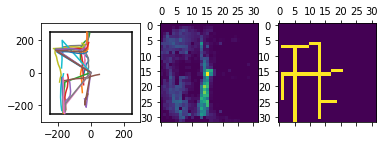

In [ ]:
id = 3500

inference(num = id)

In [ ]:
def get_unaggregated_output(input_batch, mask):
    with torch.no_grad():
        my_output = None

        def my_hook(module_, input_, output_):
            nonlocal my_output
            my_output = output_

        a_hook = model_loaded.linear_decoder.register_forward_hook(my_hook)        
        model_loaded(input_batch, mask)
        a_hook.remove()
        return my_output

In [ ]:
def inference_single_trajectories(num, traj = 0):
    x, y = collate_fn_padd([data[num]])
    batch_x, lengths, mask = x

    if model_loaded.device.type != "cuda":
        model_loaded.to(device)

    output = get_unaggregated_output(batch_x, mask)

    output = output.reshape(-1, model_loaded.w, model_loaded.h)[traj]

    print("Example ", num, ", trajectory number", traj)

    plot_result_traj(num, traj, output)

def plot_result_traj(num, traj, output):

    center = (0,0)
    size = 500
    cells = 32

    set_traj = data[num][0]
    image = data[num][1]

    fig = plt.figure()
    ax = fig.add_subplot(131)

    zoom = 1.2

    plt.xlim(center[0]-zoom*size/2, center[0]+zoom*size/2)
    plt.ylim(center[1]-zoom*size/2, center[1]+zoom*size/2)
    ax.set_aspect('equal')



    ax.plot([center[0]-size/2,center[0]+size/2], [center[1]-size/2, center[1]-size/2], c="black")
    ax.plot([center[0]-size/2,center[0]+size/2], [center[1]+size/2, center[1]+size/2], c="black")
    ax.plot([center[0]-size/2,center[0]-size/2], [center[1]-size/2, center[1]+size/2], c="black")
    ax.plot([center[0]+size/2,center[0]+size/2], [center[1]-size/2, center[1]+size/2], c="black")

    selected_traj = set_traj[traj]
    x = selected_traj[0:30:3]
    y = selected_traj[1:31:3]
    ax.plot(x, y)
        
    ax = fig.add_subplot(132)

    ax.matshow(output.squeeze(0).to("cpu").flip(0))

    ax = fig.add_subplot(133)

    ax.matshow(image.flip(0))

    plt.show()

Example  3500 , trajectory number 14


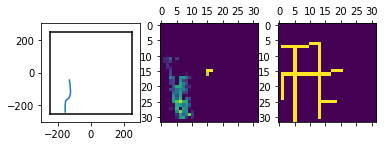

In [ ]:
id = 3500
traj = 14

inference_single_trajectories(num = id, traj = traj)

In [ ]:
for i, traj in enumerate(data[id][0]):
    for x in traj[0::3]:
        if -x < -150:
            print(i)